<h2> Capstone project: The Battle of Neighborhoods (week 2) </h2>
<h3> Business Prospect and Venues Data Analysis in Bali, Indonesia </h3> by: <b>Nur Cahyo Nugroho </b>

<img src="https://media.timeout.com/images/105240189/image.jpg" width="500" height="600">

<h3>1. Introduction</h3>
<p>Bali is one of main Indonesia's tourism destination, which has seen a significant rise in tourists since the 1980s. Tourism-related business makes up 80% of its economy. It is renowned for its highly developed arts, including traditional and modern dance, sculpture, painting, leather, metalworking, and music. There's so much business opportunity in this island, with potential customer from both local residents and the tourists. </p>
<p>Business people will need to perform research and exploration of the neighborhood before open any business in specific location to understand many factors, like nearby residential area, tourist place & office, another similar competitor, public facilities, and most importantly average rental fare.</p>

<h3>2. Objective</h3>
<p>This project will give insight to business people to comparing neighborhoods based on districts in Bali to choose best suited location based on top 10 common venues surrounding it.</p>
<p>Methods:
<ul>
    <li>Web scraping the list of district/kecamatan in Bali from Wikipedia.</li>
    <li>Extracting top trending venues using Foursquare API. </li>
    <li>Forming neighborhood clusters based on venue categories using unsupervised <i>k-means</i> clustering algorithm. </li>
    <li>Understanding the similarities and differences between district to retrieve more insights and to conclude which neighborhood is best suited for business prospect. </li>
</ul></p>

<h3>3. Data Reference and Library</h3>
<h4>3.1. District list in Bali</h4>
I will be extracting list of districts in Bali from Wikipedia page: <a href="url">https://en.wikipedia.org/wiki/Bali</a>. 
Using read_html() to extract HTML table information from Wikipedia, and Panda libraries to load it into dataframe and perform necessary data clean-up. 
<h4>3.2. Geolocation of each district in Bali</h4>
Geolocation contains longtitude and latitude of each district in Bali from csv file that I will upload in GitHub. Using panda dataframe to load the data and merge it with above district information, then get top venues using Foursquare API using geolocation information.
<h4>3.3. Library </h4>
<ul>
    <li>Panda libraries for dataframe and other dataset manipulation.</li>
    <li>Numpy for any scientific computation.</li>
    <li>Requests to call Foursquare API.</li>
    <li>KMeans cluster from sklearn for clustering.</li>
    <li>Matplotlib for plotting modules.</li>
    <li>Folium for map plotting.</li>
</ul>  

<h3>4. Python Notebook</h3>
<h4>4.1. Download and extract dataset</h4>

Import all necessary libraries:

In [89]:
import pandas as pd
import numpy as np
import requests

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
# we are using the inline backend
%matplotlib inline 

#!conda install -c anaconda beautifulsoup4 --yes
from bs4 import BeautifulSoup

#!conda install -c conda-forge geopy --yes 
#!conda install -c conda-forge folium=0.5.0 --yes

import folium # plotting library

from pandas.io.json import json_normalize

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported')

Libraries imported


Read data from Wikipedia and convert it to panda dataframe:

In [169]:
#Call from webpage url and store them as dataframes in an array, each element is a dataframe
wiki_tables = pd.read_html("https://id.wikipedia.org/wiki/Daftar_kabupaten_dan_kota_di_Bali", header=0) 

#Convert to dataframe
bali_raw_df = wiki_tables[0]
bali_raw_df.head(10)
#Bali_raw_df.dtypes

#Create new dataframe, get 'Kabupaten/Kota' and 'Jumlah penduduk (2017)' as 'District' and 'Total Population'
bali_df = bali_raw_df[['Kabupaten/kota', 'Jumlah penduduk (2017)[1]']]
bali_df.rename(columns={'Kabupaten/kota':'District', 'Jumlah penduduk (2017)[1]':'Population'}, inplace=True)
bali_df

,District,Population
0,Kabupaten Badung,468.346
1,Kabupaten Bangli,264.945
2,Kabupaten Buleleng,814.356
3,Kabupaten Gianyar,492.757
4,Kabupaten Jembrana,323.211
5,Kabupaten Karangasem,545.389
6,Kabupaten Klungkung,215.852
7,Kabupaten Tabanan,466.647
8,Kota Denpasar,638.548


Convert float 'Population' into int:

In [171]:
i=0
for pop in bali_df['Population']:
    bali_df.iloc[i,1] = int(str("{0:.3f}".format(round(pop,3))).replace('.', ''))
    i+=1

bali_df['Population'] = bali_df['Population'].astype(int)

C:\Users\nurca\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Dataframe after change datatype:

In [172]:
bali_df

,District,Population
0,Kabupaten Badung,468346
1,Kabupaten Bangli,264945
2,Kabupaten Buleleng,814356
3,Kabupaten Gianyar,492757
4,Kabupaten Jembrana,323211
5,Kabupaten Karangasem,545389
6,Kabupaten Klungkung,215852
7,Kabupaten Tabanan,466647
8,Kota Denpasar,638548


Get geolocation for each distric of Bali from csv file:

In [173]:
#read csv data and put it in dataframe
geo_df = pd.read_csv('https://raw.githubusercontent.com/bluearticuno/Coursera_Capstone/master/Bali_District_Geospatial.csv')
geo_df.head(7)

,Kabupaten/Kota,Latitude,Longitude
0,Kabupaten Badung,-8.5819,115.1771
1,Kabupaten Bangli,-8.2976,115.3549
2,Kabupaten Buleleng,-8.2239,114.9517
3,Kabupaten Gianyar,-8.4248,115.2601
4,Kabupaten Jembrana,-8.3233,114.6668
5,Kabupaten Karangasem,-8.3466,115.5207
6,Kabupaten Klungkung,-8.7278,115.5444


Merge both data:

In [174]:
merged_df = pd.merge(left=bali_df, right=geo_df, left_on='District', right_on='Kabupaten/Kota')
merged_df.drop(['Kabupaten/Kota'], axis=1, inplace=True)
merged_df

,District,Population,Latitude,Longitude
0,Kabupaten Badung,468346,-8.5819,115.1771
1,Kabupaten Bangli,264945,-8.2976,115.3549
2,Kabupaten Buleleng,814356,-8.2239,114.9517
3,Kabupaten Gianyar,492757,-8.4248,115.2601
4,Kabupaten Jembrana,323211,-8.3233,114.6668
5,Kabupaten Karangasem,545389,-8.3466,115.5207
6,Kabupaten Klungkung,215852,-8.7278,115.5444
7,Kabupaten Tabanan,466647,-8.4596,115.0466
8,Kota Denpasar,638548,-8.6705,115.2126


Create map of Bali:

In [175]:
# create map of Bali using latitude and longitude values
bali_map = folium.Map(location=[-8.34, 115.09], zoom_start=9)

# add markers to map
for lat, lng, district in zip(merged_df['Latitude'], merged_df['Longitude'], merged_df['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(bali_map)  
    
bali_map

In [178]:
#merged_df.set_index('District', inplace=True)
#merged_df.set_index('District')

#merged_df.reset_index() 
#merged_df

,District,Population,Latitude,Longitude
0,Kabupaten Badung,468346,-8.5819,115.1771
1,Kabupaten Bangli,264945,-8.2976,115.3549
2,Kabupaten Buleleng,814356,-8.2239,114.9517
3,Kabupaten Gianyar,492757,-8.4248,115.2601
4,Kabupaten Jembrana,323211,-8.3233,114.6668
5,Kabupaten Karangasem,545389,-8.3466,115.5207
6,Kabupaten Klungkung,215852,-8.7278,115.5444
7,Kabupaten Tabanan,466647,-8.4596,115.0466
8,Kota Denpasar,638548,-8.6705,115.2126


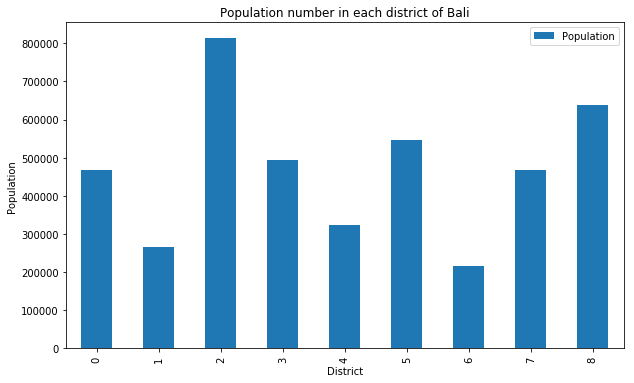

In [179]:
merged_df.loc[:, ['District', 'Population']].plot(kind='bar', figsize=(10, 6))
plt.title('Population number in each district of Bali')
plt.xlabel('District')
plt.ylabel('Population')
plt.show()